In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as tr
from torch.autograd import Variable
import os 
import PIL.Image as Image
from IPython.display import display
import matplotlib.pyplot as plt

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(device) if device.index == 0 else 'cpu') 

Tesla P100-PCIE-16GB


In [29]:
train_transforms = tr.Compose([tr.Resize(226),
                              tr.CenterCrop(224),
                              tr.RandomHorizontalFlip(),
                              tr.RandomRotation(15),
                              tr.ToTensor(),
                              tr.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = tr.Compose([tr.Resize(226),
                              tr.CenterCrop(224),
                              tr.ToTensor(),
                              tr.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [30]:
b_s = 64

In [31]:
tr_data = torchvision.datasets.ImageFolder(root='../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/', transform=train_transforms)
ts_data = torchvision.datasets.ImageFolder(root='../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/', transform=test_transforms)
tr_load = torch.utils.data.DataLoader(dataset = tr_data, batch_size = b_s, shuffle = True, pin_memory = True, num_workers = 4)
ts_load = torch.utils.data.DataLoader(dataset = ts_data, batch_size = b_s, shuffle = True, pin_memory = True, num_workers = 4)

In [32]:
model = models.resnet101(pretrained = True)
model.fc = nn.Linear(2048, 196)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [33]:
loss_function = nn.CrossEntropyLoss()
lr = 0.01
optimiz = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
lr_sr = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimiz, mode = 'max', patience = 3)

In [34]:
model.to(device);

In [35]:
def train(epochs, model, optimizer, lr_sr, loss_func):
    
    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    num_ep = 0
    
    losses = []
    acc_train = []
    acc_test = []
    
    for i in range(epochs):
        model.train()
        num_ep += 1 
        epochs_loss = 0.0
        epochs_corr = 0.0
        for i, (images, labels) in enumerate(tr_load):
            
            data = Variable(images.view(len(labels), 3, 224, 224))
            labels = Variable(labels)
            
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            out = model(data)
            
            _, predict = torch.max(out.data, 1)
            
            loss = loss_func(out, labels)
            
            loss.backward()
            
            optimizer.step()
            
            epochs_loss += loss.item()
            
            epochs_corr += (labels == predict).sum().item()
            
        model.eval()
        
        correct = 0.0
        labelss = 0.0
        with torch.no_grad():
            for i, (images, labels) in enumerate(ts_load):
                images, labels = images.to(device), labels.to(device)
                
                outs  = model(images)
                
                _, predic = torch.max(outs.data, 1)
                
                correct += (predic == labels).sum().item()
                labelss += labels.size(0)
        
        test_acc = 100.0 * (correct/labelss)
        
        model.train()
        
        lr_sr.step(test_acc)
        
        epochs_loss = epochs_loss/len(tr_load)
        
        train_acc = 100/64*epochs_corr/len(tr_load)
        
        print('Epoch: {}, train_loss: {}, train_acc: {}, test_acc: {}, lr: {}'.format(num_ep, epochs_loss, train_acc, test_acc, get_lr(optimizer)))
        
        
        losses.append(epochs_loss)
        acc_train.append(train_acc)
        acc_test.append(test_acc)
    
    return model, losses, acc_train, acc_test
                

In [36]:
model, losses, acc_train, acc_test = train(30, model, optimiz, lr_sr, loss_function)

Epoch: 1, train_loss: 4.2634536530822515, train_acc: 11.60888671875, test_acc: 29.02624051734859, lr: 0.01
Epoch: 2, train_loss: 1.99721416272223, train_acc: 47.998046875, test_acc: 49.59582141524686, lr: 0.01
Epoch: 3, train_loss: 1.053824383765459, train_acc: 70.99609375, test_acc: 63.785598806118635, lr: 0.01
Epoch: 4, train_loss: 0.6527650293428451, train_acc: 81.787109375, test_acc: 68.61086929486382, lr: 0.01
Epoch: 5, train_loss: 0.410473300376907, train_acc: 88.26904296875, test_acc: 72.39149359532396, lr: 0.01
Epoch: 6, train_loss: 0.2629581682267599, train_acc: 92.7490234375, test_acc: 77.66446959333416, lr: 0.01
Epoch: 7, train_loss: 0.182578521897085, train_acc: 94.98291015625, test_acc: 79.41798283795548, lr: 0.01
Epoch: 8, train_loss: 0.12012085897731595, train_acc: 96.4599609375, test_acc: 82.4524312896406, lr: 0.01
Epoch: 9, train_loss: 0.08144389580411371, train_acc: 97.64404296875, test_acc: 82.61410272354185, lr: 0.01
Epoch: 10, train_loss: 0.062141631889971904, trai

Text(0.5, 1.0, 'Test acc')

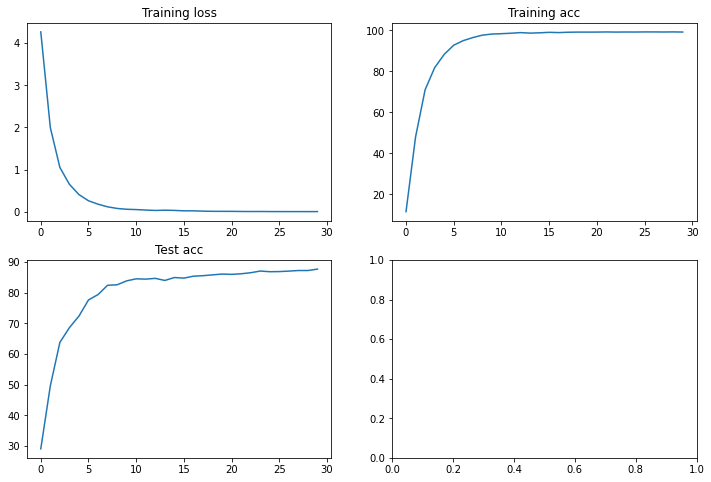

In [37]:
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(acc_train)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(acc_test)

axarr[1, 0].set_title("Test acc")

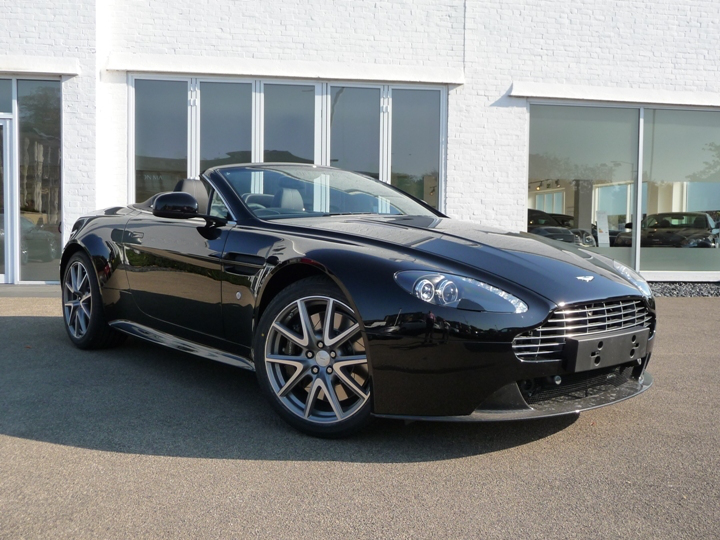

Aston Martin V8 Vantage Convertible 2012 confidence:  4.836994647979736


In [40]:
path = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Aston Martin V8 Vantage Convertible 2012/00239.jpg'
model.eval()
loader = tr.Compose([tr.Resize((400, 400)),
                                tr.ToTensor(),
                                tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(path)
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model(image)
conf, predicted = torch.max(output.data, 1)
display(Image.open(path))
print(classes[predicted.item()], "confidence: ", conf.item())

In [43]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/')
classes

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [ ]:
torch.save(model.state_dict(), 'model_stat_dict.pt')